# Whatsapp Text Analysis

I thought it would be cool to see some trends with my texts so here is a fun script using Whatsapp exported texts. 
To get the txt file from Whatsapp, go to the desired chat, press the three dots, go to "more", and pick the "Export chat" option.

In [1]:
text_file = "WhatsApp Chat with Lara Buri.txt"

## Required packages 

In [2]:
import pandas as pd
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
from wordcloud import WordCloud, STOPWORDS
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pattern.en import sentiment as sentiment_en

## Processing of Text

Import .txt file into a pandas dataframe

In [3]:
df = pd.read_csv(text_file,header=None,error_bad_lines=False,encoding='utf8')
df = df.drop(0)
df = df.drop(columns = [2,3])
df.columns = ['Date','Text']

b'Skipping line 3070: expected 4 fields, saw 6\nSkipping line 4336: expected 4 fields, saw 5\nSkipping line 5392: expected 4 fields, saw 5\nSkipping line 6706: expected 4 fields, saw 5\nSkipping line 8480: expected 4 fields, saw 7\n'


In [4]:
df.head(3)

Date                                             Text
1  3/5/20   15:14 - Jason Li: Can I text you here instead?
2  3/5/20               15:31 - Lara Buri: Yes this works!
3  3/5/20                15:35 - Jason Li: <Media omitted>

Split the time according to the ":" delimiter. Thank you Whatsapp for putting the data in a sensible format.

In [5]:
Chat = df['Text'].str.split('-', n=1, expand=True)
df['Time'] = Chat[0]
df['Content'] = Chat[1]
df = df.drop(columns = 'Text')

In [6]:
df.head()

Date     Time                                  Content
1  3/5/20   15:14    Jason Li: Can I text you here instead?
2  3/5/20   15:31                Lara Buri: Yes this works!
3  3/5/20   15:35                 Jason Li: <Media omitted>
4  3/5/20   15:35       Jason Li: Is your mouth normal now?
5  3/5/20   15:35                  Lara Buri: It's printed!

Get the messager for each message

In [7]:
Chat1 = df['Content'].str.split(':', n=1, expand=True)
df['User'] = Chat1[0]
df['Message'] = Chat1[1]
df = df.drop(columns = 'Content')

In [8]:
df.head()

Date     Time        User                        Message
1  3/5/20   15:14     Jason Li   Can I text you here instead?
2  3/5/20   15:31    Lara Buri                Yes this works!
3  3/5/20   15:35     Jason Li                <Media omitted>
4  3/5/20   15:35     Jason Li      Is your mouth normal now?
5  3/5/20   15:35    Lara Buri                  It's printed!

Make sure the columns are in sane formats.

In [9]:
df['Date'] = df['Date'].astype('str')
df['Time'] = df['Time'].astype('str').str.strip()
df['User'] = df['User'].astype('str').str.strip()
df['Message'] = df['Message'].astype('str').str.lstrip()

In [10]:
df.head()

Date   Time       User                       Message
1  3/5/20  15:14   Jason Li  Can I text you here instead?
2  3/5/20  15:31  Lara Buri               Yes this works!
3  3/5/20  15:35   Jason Li               <Media omitted>
4  3/5/20  15:35   Jason Li     Is your mouth normal now?
5  3/5/20  15:35  Lara Buri                 It's printed!

Get rid of the media omitted message 

In [11]:
df = df[df['Message'] != df['Message'][3]]
df.head()

Date   Time       User                       Message
1  3/5/20  15:14   Jason Li  Can I text you here instead?
2  3/5/20  15:31  Lara Buri               Yes this works!
4  3/5/20  15:35   Jason Li     Is your mouth normal now?
5  3/5/20  15:35  Lara Buri                 It's printed!
6  3/5/20  15:35  Lara Buri             Umm mostly normal

Parse the date and time columns into, you guessed it, a datetime column

In [12]:
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], errors ='coerce')
df = df[pd.notnull(df['Datetime'])]


In [13]:
df.head()

Date   Time       User                       Message            Datetime
1  3/5/20  15:14   Jason Li  Can I text you here instead? 2020-03-05 15:14:00
2  3/5/20  15:31  Lara Buri               Yes this works! 2020-03-05 15:31:00
4  3/5/20  15:35   Jason Li     Is your mouth normal now? 2020-03-05 15:35:00
5  3/5/20  15:35  Lara Buri                 It's printed! 2020-03-05 15:35:00
6  3/5/20  15:35  Lara Buri             Umm mostly normal 2020-03-05 15:35:00

Save the words for word map

In [14]:
dfwords = df['Message']
pd.Series.to_csv(dfwords,'word_map_input.txt', index = False, header = False, encoding = 'utf-16')

# Analysis

### Count of Messages

Faily simple split 

In [15]:
df.groupby(by='User').count()

Date  Time  Message  Datetime
User                                    
Jason Li   4295  4295     4295      4295
Lara Buri  4336  4336     4336      4336

### Average time of day to send a message

Ok this problem was way more complicated than I originally thought it was be. Initially I thought I could just take the mean of the times of day to get the average time of day we send a message. However, it because of the overlap at 24 hours, a message sent at 0:01 and 23:59 would average to 12 instead of 0. So in order to average these times, I treated them like degrees on the unit circle on a cartesian graph. By getting the centroid of these messages, I could then determine its corresponding angle to get average time.

In [16]:
def get_mean_time(datetime_list):
    times =[x.time() for x in datetime_list]
    seconds_of_day = [x.hour * 3600 + x.minute*60 + x.second for x in times]
    
    #convert to radians
    angle_of_day = np.asarray(seconds_of_day)/86400 * (2 * np.pi)
    x, y = np.cos(angle_of_day), np.sin(angle_of_day)
    sum_x, sum_y = np.nansum(x), np.nansum(y)
    length = len(x[np.isfinite(x)])

    #calculate centroid
    centroid = (sum_x/length, sum_y/length)
    mean_time_rad = np.arctan2(centroid[0], centroid[1])
    if mean_time_rad < 0:
        mean_time_rad = 2*np.pi + mean_time_rad
        
    mean_seconds_of_day = mean_time_rad / (2*np.pi) * 86400
    hour, rem = divmod(mean_seconds_of_day, 3600)
    minutes,seconds = divmod(rem,60)
    
    return datetime.time(hour = int(hour), minute = int(minutes), second= int(seconds))



In [17]:
User_group = df.groupby(by='User')
User_group['Datetime'].agg([get_mean_time])

get_mean_time
User                   
Jason Li       13:48:39
Lara Buri      13:50:46

# Time Series Sentiment Analysis

The NLP of sentiment analysis is a little out of my scope, but I thought it would be fun to see if there were any obvious trends. It's a scale from -1 to 1 (1 = good, -1 = bad). 

In [18]:
df['Sentiment'] = df.apply(lambda row: 
                           sentiment_en(row.Message)[0], 1)

In [19]:
df.head()

Date   Time       User                       Message            Datetime  \
1  3/5/20  15:14   Jason Li  Can I text you here instead? 2020-03-05 15:14:00   
2  3/5/20  15:31  Lara Buri               Yes this works! 2020-03-05 15:31:00   
4  3/5/20  15:35   Jason Li     Is your mouth normal now? 2020-03-05 15:35:00   
5  3/5/20  15:35  Lara Buri                 It's printed! 2020-03-05 15:35:00   
6  3/5/20  15:35  Lara Buri             Umm mostly normal 2020-03-05 15:35:00   

   Sentiment  
1       0.00  
2       0.00  
4       0.15  
5       0.00  
6       0.15

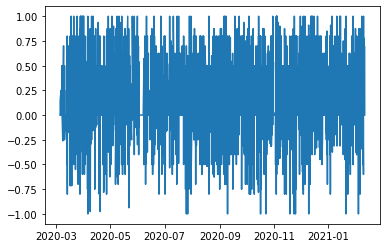

In [20]:
plt.plot(df['Datetime'],df['Sentiment'])

Yep, we're human so a lot of sentiment: both good and bad.
Since it's pretty hard to discern anything from this, I thought a simple rolling mean could make it possible to see general trends.

In [21]:
#rolling mean of sentiment
rolling_windows = df['Sentiment'].rolling(100,min_periods = 1).mean()

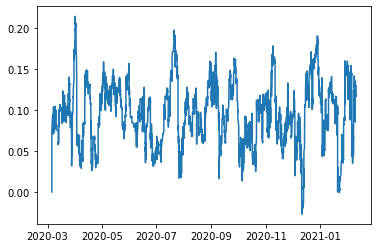

In [22]:
plt.plot(df['Datetime'],rolling_windows)

Yay, an overall positive sentiment. It's interesting to see the periodicity of it. There's probably some correlation to real life events.

# Build the word map

Lastly, I thought it would be cool to see what our most common words are. For this, we omit the stop words in english (eg. the, it, I)

In [23]:
f = open('word_map_input.txt', encoding='utf16')
text = f.read()
stopwords=set(STOPWORDS)
stopwords.add("said")

In [24]:
wordcloud = WordCloud(stopwords=stopwords, width=800, height=800,background_color="white",max_words=1000, max_font_size=256, scale = 5).generate(text)

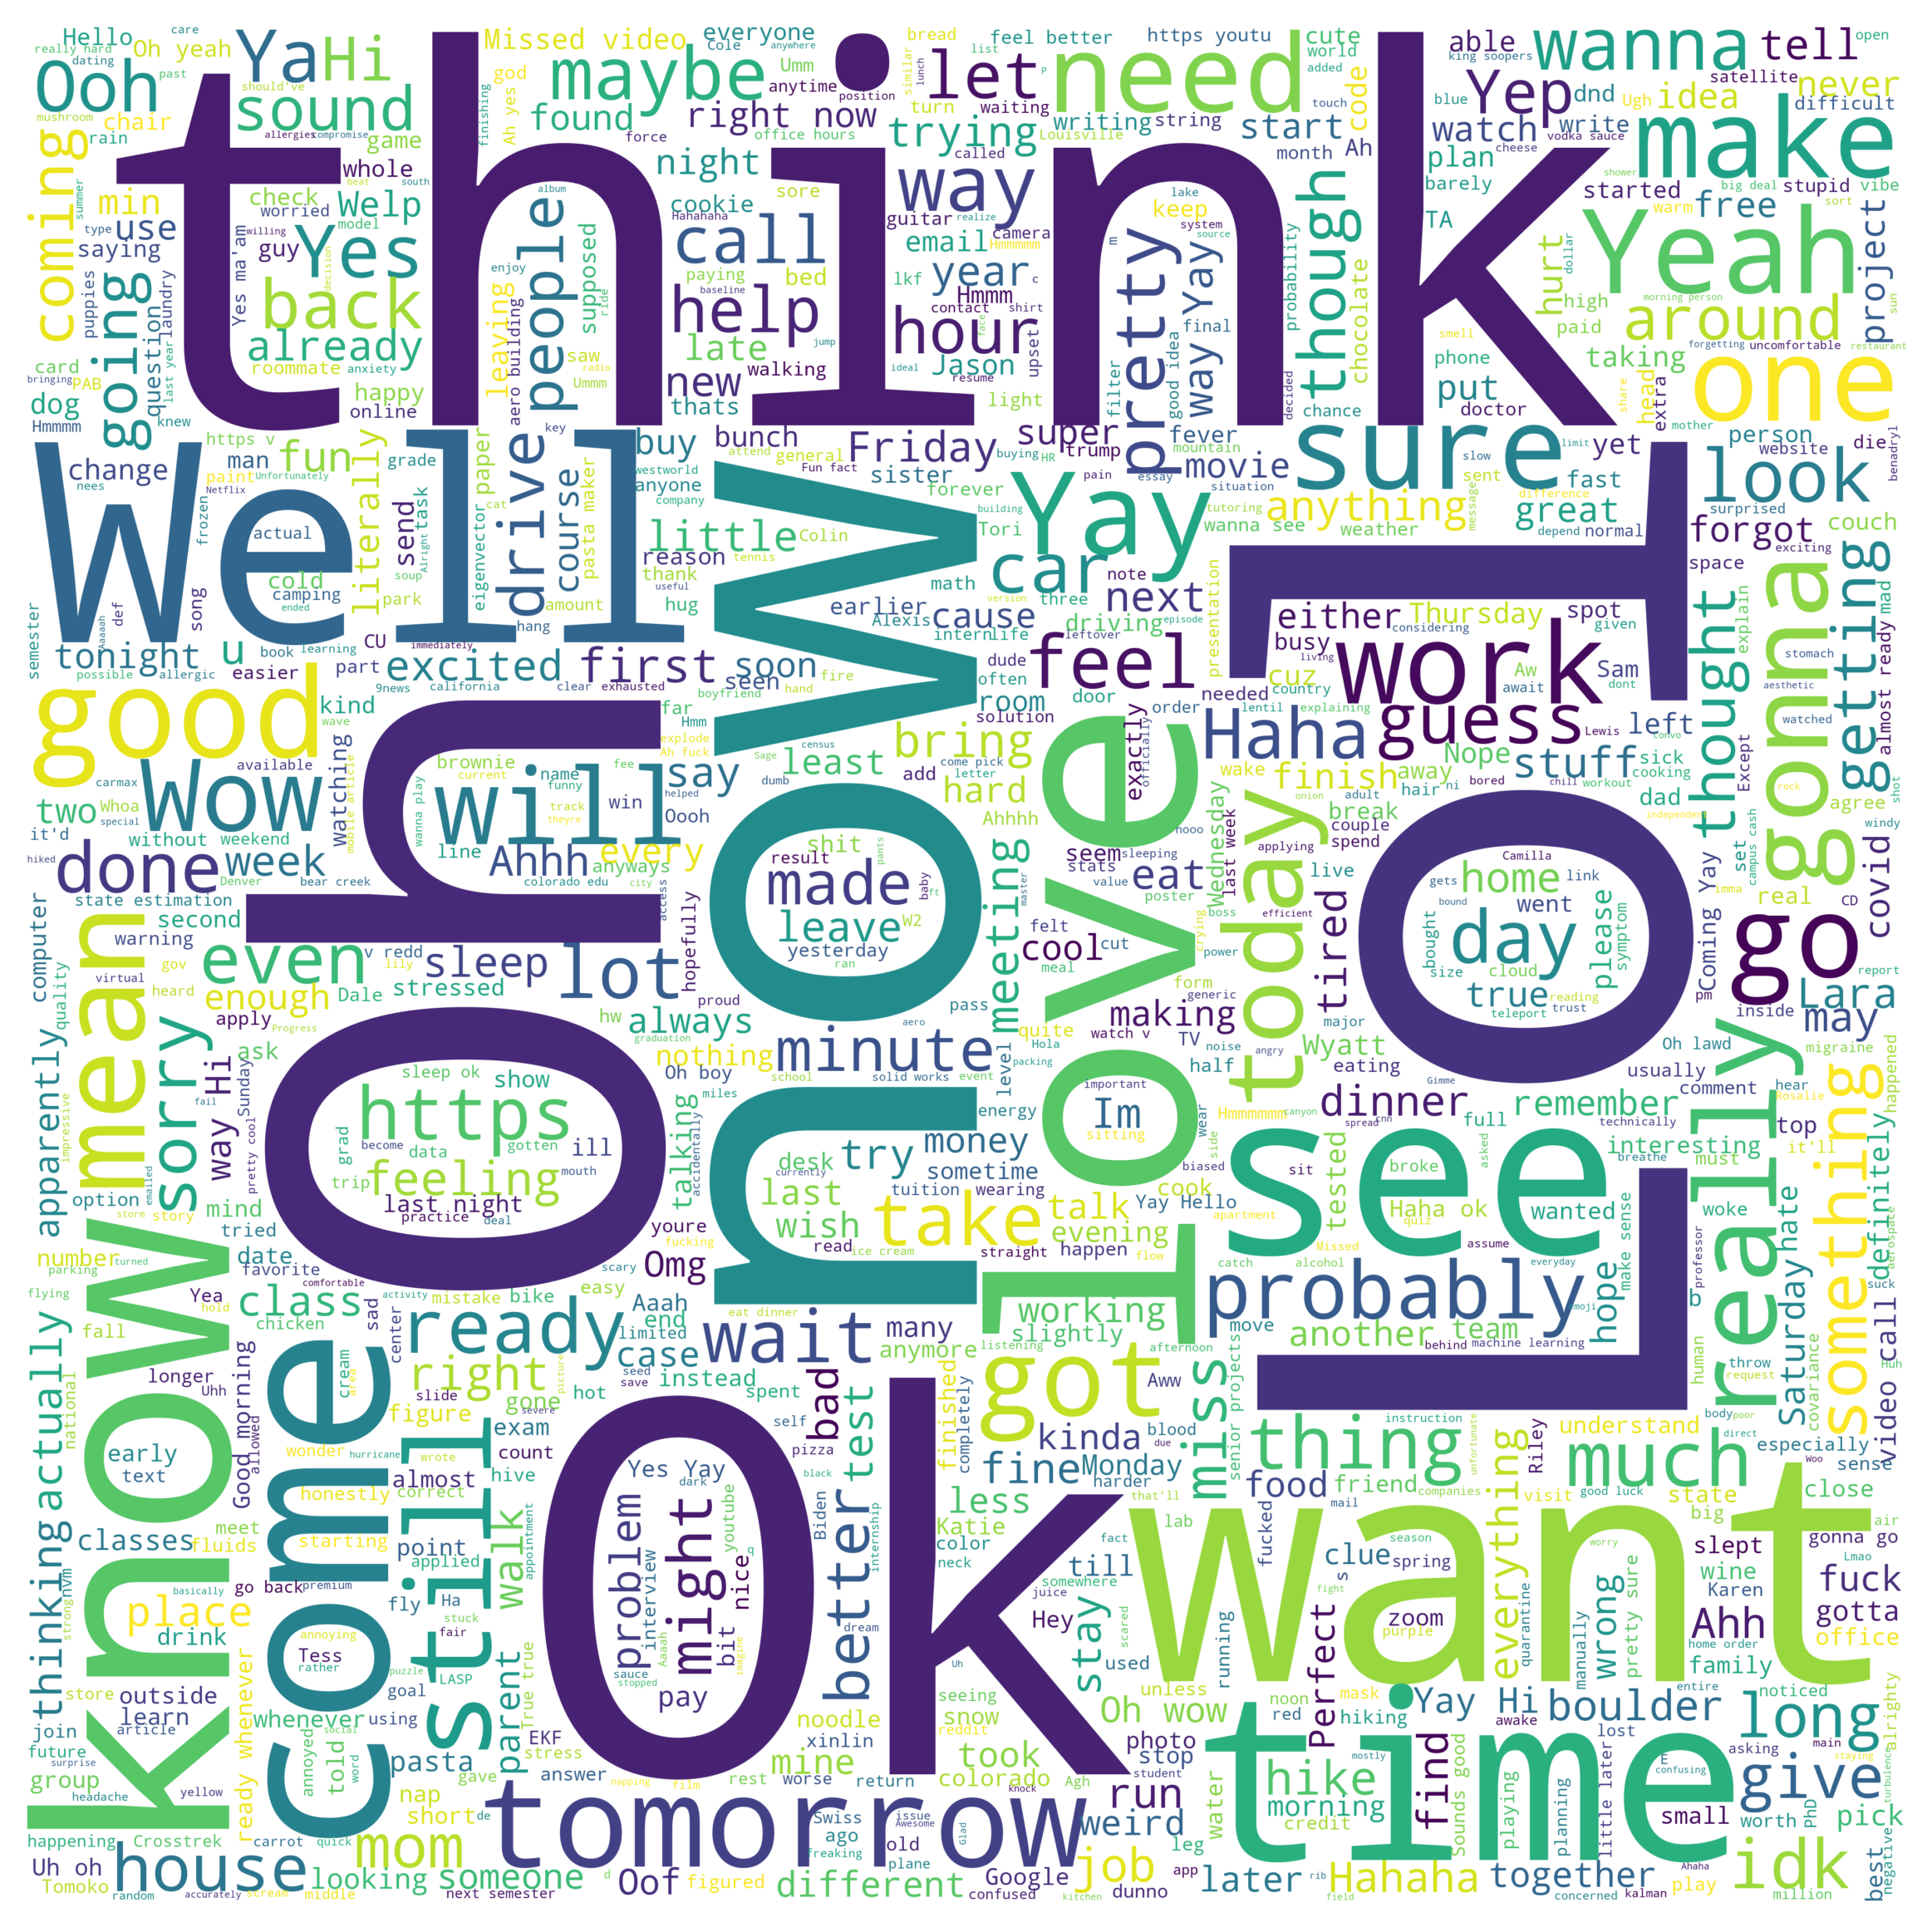

In [25]:
plt.figure(dpi = 300, figsize = (10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordmap.png')

## Word map but better

This package is pretty nice so you can add contour images that contain the words. Heads up though, if the contour image is low quality, you will have to up the scale factor,

In [26]:
mask = np.array(Image.open('penguin2.png'))

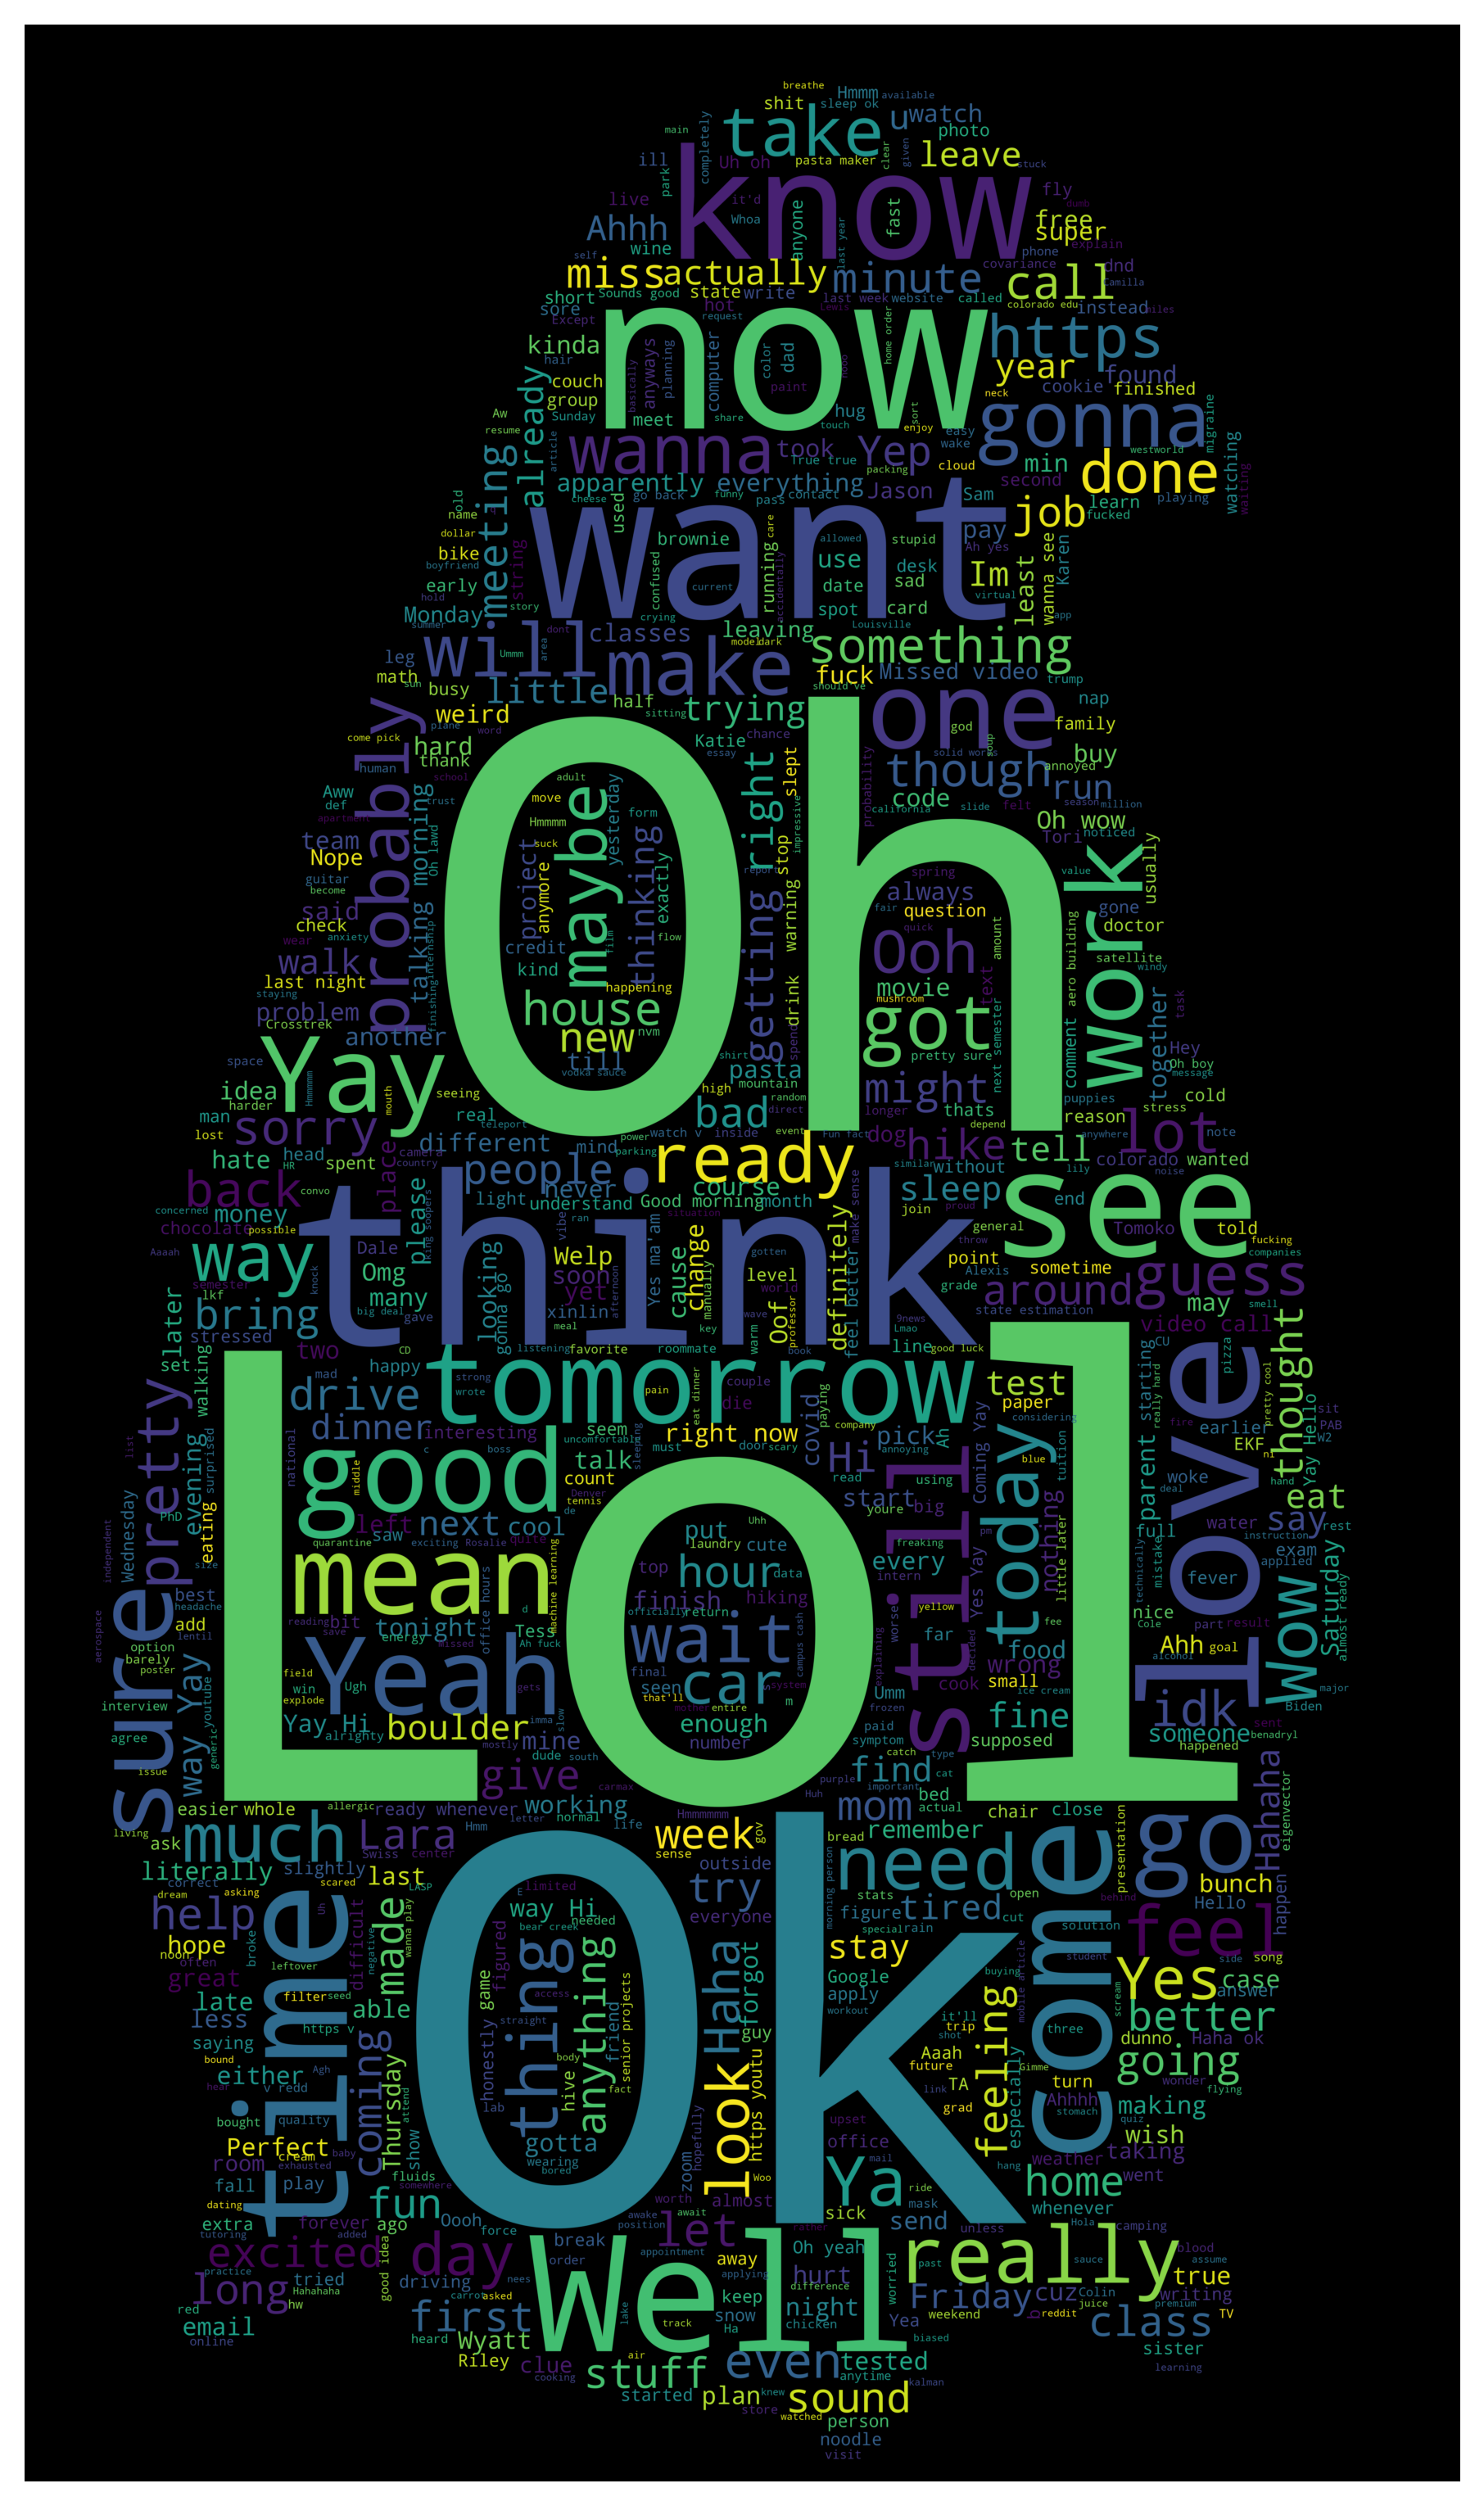

In [27]:
wc = WordCloud(stopwords=STOPWORDS, 
               mask=mask,
               max_words=1000, max_font_size=256,
               random_state=42,
               width=800,
               height=800,
               scale = 10)
wc.generate(text)
plt.figure(dpi = 300, figsize = (10,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('map_peng.jpg',bbox_inches='tight')